In [261]:
import xarray as xr
import numpy as np
import matplotlib.pyplot
# spatial subscript
state_names = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', 'District of Columbia']

# non-spatial subscript
variant_list = ["Delta", 'Omicron', "BA5"]
vax_status_list = ['Vx', 'NVx']

state_lst_1=[]
state_lst_2=[]
state_lst_3=[]
state_lst_4=[]
state_lst_5=[]
state_lst_6=[]
for name in state_names:
    state_lst_1.append(f"Impact of Treatment on Fatality Rate[{name}]")
    state_lst_2.append(f"Base Fatality Rate for Unit Acuity[{name}]")
    state_lst_3.append(f"Reference Force of Infection[{name}]")
    state_lst_4.append(f"Strength of Adherence Fatigue[{name}]")
    state_lst_5.append(f"Variant Intro Start Time[{name}]")
    state_lst_6.append(f"Variant Intro Start Time2[{name}]")

param_lst_lst=[
    state_lst_1, # ['Impact of Treatment on Fatality Rate[Alabama]', 'Impact of Treatment on Fatality Rate[Alaska]' ...]
    state_lst_2,
    state_lst_3,
    state_lst_4,
    state_lst_5,
    state_lst_6,
    ['Extra Vaccine Impact on Responsiveness[Vx]'],
    ['Extra Vaccine Impact on Responsiveness[NVx]'],
    ['Extra Vaccine Impact on Responsiveness[Naive]'],
    ['Immunity Loss Time[Vx]'],
    ['Immunity Loss Time[NVx]'],
    ['Immunity Loss Time[Naive]'],
    ['Variant Accuity Multiplier[Omicron]'],
    ['Variant Accuity Multiplier[Delta]'],
    ['Variant Accuity Multiplier[BA5]'],
    ['Variant Impact on Immunity Loss Time[Omicron]'],
    ['Variant Impact on Immunity Loss Time[Delta]'],
    ['Variant Impact on Immunity Loss Time[BA5]'],
    ['Variant Intro Start Time3'],
    ['Variant Transmission Multiplier[Omicron]'],
    ['Variant Transmission Multiplier[Delta]'],
    ['Variant Transmission Multiplier[BA5]']
]

vv_param_names=['Variant Impact on Immunity Loss Time[Omicron]',
 'Variant Impact on Immunity Loss Time[Delta]',
 'Variant Impact on Immunity Loss Time[BA5]',
 'Impact of Treatment on Fatality Rate',
 'Base Fatality Rate for Unit Acuity',
 'Reference Force of Infection',
 'Strength of Adherence Fatigue',
 'Variant Intro Start Time',
 'Variant Intro Start Time2',
 'Extra Vaccine Impact on Responsiveness[Vx]',
 'Extra Vaccine Impact on Responsiveness[NVx]',
 'Extra Vaccine Impact on Responsiveness[Naive]',
 'Immunity Loss Time[Vx]',
 'Immunity Loss Time[NVx]',
 'Immunity Loss Time[Naive]',
 'Variant Accuity Multiplier[Omicron]',
 'Variant Accuity Multiplier[Delta]',
 'Variant Accuity Multiplier[BA5]',
 'Variant Intro Start Time3',
 'Variant Transmission Multiplier[Omicron]',
 'Variant Transmission Multiplier[Delta]',
 'Variant Transmission Multiplier[BA5]']


## 1. Define xarray structure to store elasticity
xarray is a labeled multidimensional data structure with `dims`,`coords` (value of `dims`), `data_vars`. Greatest benefit for spatio-temportal sensitivity using this structure is a function `.sum()`. With this command exemplified below, we can add along specificed axis (e.g. `component` (death, gdp, hospitalization), `space` (51 states)).

In [262]:
dv = {
    "coords": {
        'value': {"dims": ("value"), "data": ["marginal", "average"]},
        'component': {"dims": ("component"),  "data": ['death', 'gdp', 'hospitalization']},
        'params': {"dims": ("params"), "data": [param for param in vv_param_names]},
        'space': {"dims" : ("space"), "data": state_names}
    },
    "dims": {"value", "component", "params"},
    "data_vars":{ #5+ 3
        'VV_csv': {"dims": ("component","space", "value"), "data": np.zeros(shape = (3, len(state_names), 2))},
        'VV_cv': {"dims": ("component", "value"), "data": np.zeros(shape = (3, 2))},
        'VV_sv': {"dims": ("space", "value"), "data": np.zeros(shape = (len(state_names), 2))},
        'VV_v': {"dims": ("value"), "data": np.zeros(shape = (2))},

        'VV_1_pcsv': {"dims": ("params", "component", "space", "value"), "data": np.zeros(shape = (len(vv_param_names),3,len(state_names), 2))},
        'VV_1_pcv': {"dims": ("params", "component", "value"), "data": np.zeros(shape = (len(vv_param_names),3, 2))},
        'VV_1_pv': {"dims": ("params", "value"), "data": np.zeros(shape = (len(vv_param_names), 2))},

        'epsilon_pv': {"dims": ("params", "value"), "data": np.zeros(shape = (len(vv_param_names), 2))},
        'epsilon_pcv': {"dims": ("params", "component", "value"), "data": np.zeros(shape = (len(vv_param_names), 3, 2))},
    },
   "attrs": {"title": "vaccine value disaggregated by parameter, time, space, component"}
    }
vds = xr.Dataset.from_dict(dv)
vds

<xarray.Dataset>
Dimensions:      (value: 2, component: 3, params: 22, space: 51)
Coordinates:
  * value        (value) <U8 'marginal' 'average'
  * component    (component) <U15 'death' 'gdp' 'hospitalization'
  * params       (params) <U45 'Variant Impact on Immunity Loss Time[Omicron]...
  * space        (space) <U20 'Alabama' 'Alaska' ... 'District of Columbia'
Data variables:
    VV_csv       (component, space, value) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    VV_cv        (component, value) float64 0.0 0.0 0.0 0.0 0.0 0.0
    VV_sv        (space, value) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    VV_v         (value) float64 0.0 0.0
    VV_1_pcsv    (params, component, space, value) float64 0.0 0.0 ... 0.0 0.0
    VV_1_pcv     (params, component, value) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    VV_1_pv      (params, value) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    epsilon_pv   (params, value) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    epsilon_pcv  (params, component, value) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    title:    vaccine value disaggregated by parameter, time, space, component

## 2. store vensim values into xarray

In [266]:
#51 states * 4 (efficacy of  death, gdp, health, population)
# row 0, 4-54 (csv's 6-56) -> 1 set, death
# row 1,55 -105 (csv's 57-107)-> 2 set, gdp
# row 2, 106-156(csv's 108-158) -> 3 set, hosp

# BASELINE HAPPENS ONCE
avg = pd.read_csv("marg_cost_per_person_base.tsv", sep="\t", index_col=0)
marg = pd.read_csv("avg_cost_per_person_base.tsv", sep="\t", index_col=0)
vds['VV_csv'].loc[dict(component = 'death', value = 'average')] = avg.loc[4:54].values.flatten()
vds['VV_csv'].loc[dict(component = 'gdp', value = 'average')] = avg.loc[55:105].values.flatten()
vds['VV_csv'].loc[dict(component = 'hospitalization',value= 'average')] = avg.loc[106:156].values.flatten()

vds['VV_csv'].loc[dict(component = 'death', value = 'marginal')] = marg.loc[4:54].values.flatten()
vds['VV_csv'].loc[dict(component = 'gdp', value = 'marginal')] = marg.loc[55:105].values.flatten()
vds['VV_csv'].loc[dict(component ='hospitalization', value ='marginal')] = marg.loc[106:156].values.flatten()

vds['VV_cv'] = vds['VV_csv'].sum(dim = 'space')
vds['VV_sv'] = vds['VV_csv'].sum(dim = 'component')
vds['VV_v'] = vds['VV_cv'].sum(dim = 'component')

# COUNTERFACTUAL HAPPENS 22 times
for file_param, param in zip(vv_param_names, vv_param_names):
    print(file_param)
    file = file_param.replace(" ", "_")
    print(file)
    avg=pd.read_csv(file +'_avg.tsv', sep='\t', index_col=0)
    marg=pd.read_csv(file+'_marg.tsv', sep='\t', index_col=0)
    print(avg)
    print(marg)

    vds['VV_1_pcsv'].loc[dict(params = param, component = 'death', value='average')] = avg.loc[4:54].values.flatten()
    vds['VV_1_pcsv'].loc[dict(params = param,component = 'gdp', value='average')] = avg.loc[55:105].values.flatten()
    vds['VV_1_pcsv'].loc[dict(params = param,component = 'hospitalization', value='average')] = avg.loc[106:156].values.flatten()

    vds['VV_1_pcsv'].loc[dict(params = param, component = 'death', value='marginal')] = marg.loc[4:54].values.flatten()
    vds['VV_1_pcsv'].loc[dict(params = param,component = 'gdp', value='marginal')] = marg.loc[55:105].values.flatten()
    vds['VV_1_pcsv'].loc[dict(params = param,component = 'hospitalization', value='marginal')] = marg.loc[106:156].values.flatten()

    vds['VV_1_pcv'] = vds['VV_1_pcsv'].sum(dim = 'space')
    vds['VV_1_pv'] = vds['VV_1_pcv'].sum(dim = 'component')

vds

Variant Impact on Immunity Loss Time[Omicron]
Variant_Impact_on_Immunity_Loss_Time[Omicron]
            0
0   -0.257579
1   -0.228044
2   -0.214592
3   -0.255473
4   -0.138037
..        ...
203 -0.235128
204 -0.202591
205 -0.132371
206 -0.101861
207 -0.163436

[208 rows x 1 columns]
            0
0   -0.386754
1   -0.202840
2   -0.311042
3   -0.366402
4   -0.503778
..        ...
203 -0.419896
204 -0.251465
205 -0.348542
206 -0.198660
207 -0.186697

[208 rows x 1 columns]
Variant Impact on Immunity Loss Time[Delta]
Variant_Impact_on_Immunity_Loss_Time[Delta]
            0
0   -0.458634
1   -0.206116
2   -0.175895
3   -0.440871
4   -0.345093
..        ...
203 -0.442428
204 -0.309644
205 -0.310406
206 -0.220215
207 -0.258530

[208 rows x 1 columns]
            0
0   -0.604303
1   -0.000000
2   -0.311042
3   -0.536821
4   -1.007557
..        ...
203 -0.423852
204 -0.237424
205  0.012806
206 -0.282838
207 -0.015275

[208 rows x 1 columns]
Variant Impact on Immunity Loss Time[BA5]
Variant_Im

FileNotFoundError: [Errno 2] No such file or directory: 'Impact_of_Treatment_on_Fatality_Rate_avg.tsv'

Average and marginal value of vaccine is stored in vds['VV_1_pv'] whose gap with vds['VV_v'] is divided by vds['VV_v']. Then this sensitivity of marginal vaccine value is divided by 0.01 (which is how much we increased each parameter).

## 3. plot and store

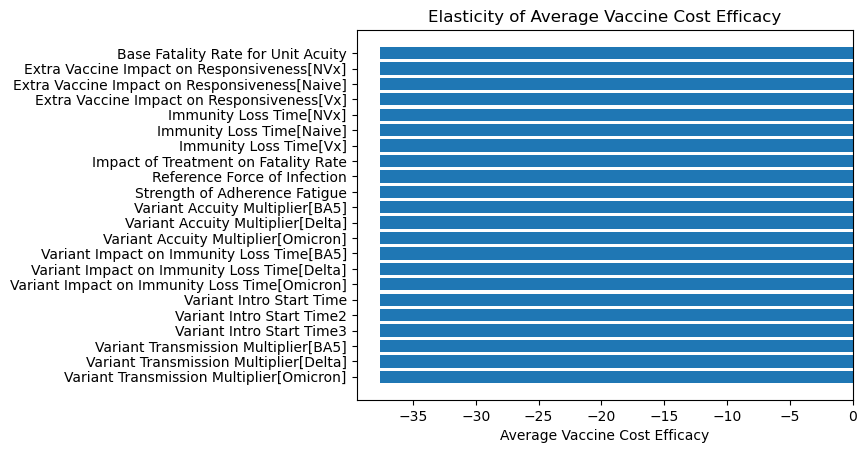

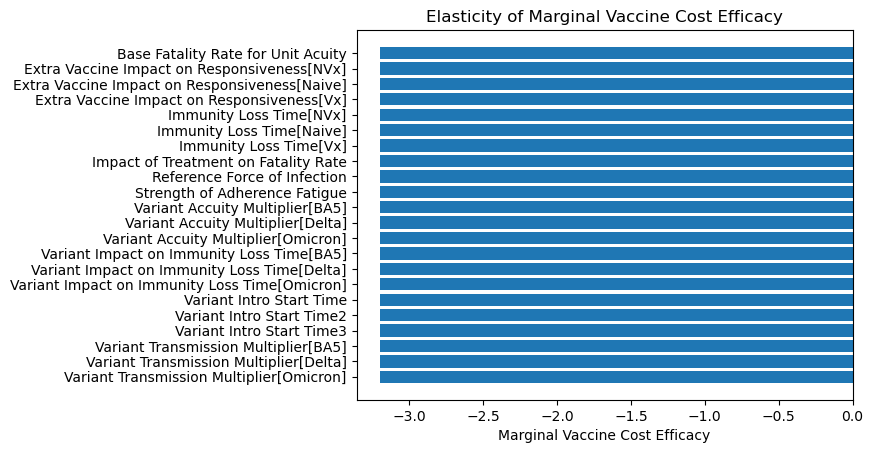

In [250]:
plot_sensitivity(vds)

In [205]:
vds.to_netcdf("vaccine_cost_efficiency_elasticity.nc")

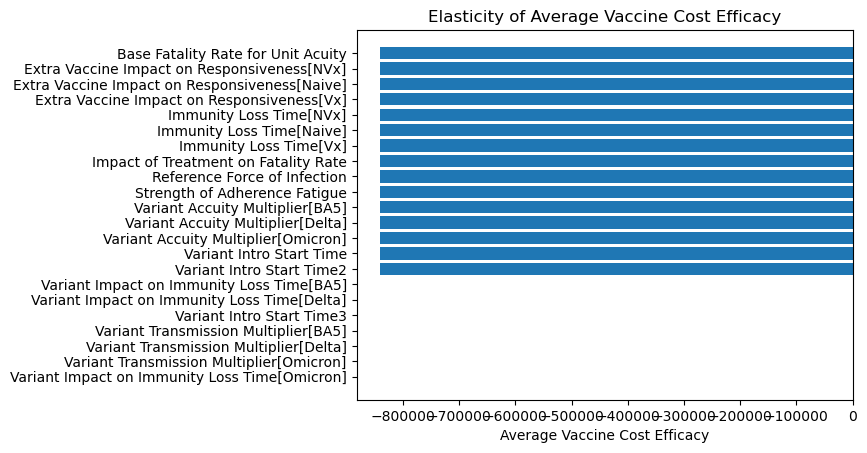

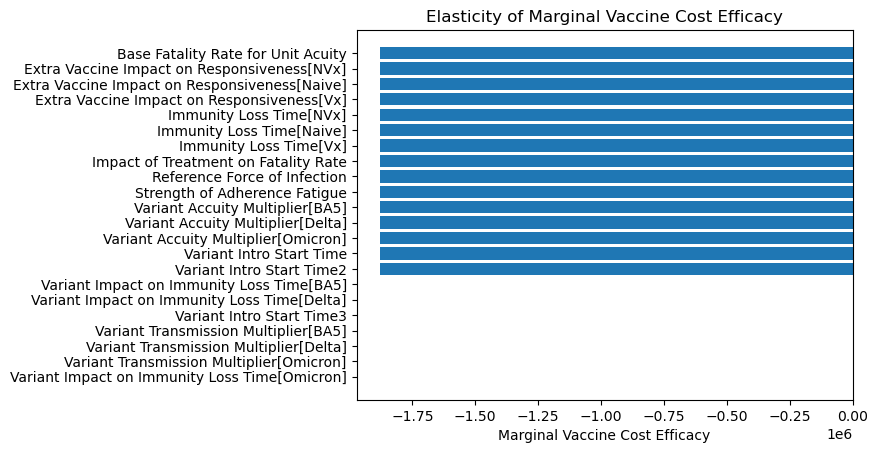

In [215]:

def plot_sensitivity(vds):
    matplotlib.pyplot.rcdefaults()
    fig_avg, ax_avg = matplotlib.pyplot.subplots()
    fig_marg, ax_marg = matplotlib.pyplot.subplots()

    x_avg=[avg for marg, avg in vds['VV_1_pv'].values]
    x_marg=[marg for marg, avg in vds['VV_1_pv'].values]
    x_label=[val for val in vds.params.values]
    y_vars=[x for x in range(len(vds['VV_1_pv']))]
    x_avg_sorted=[]
    x_marg_sorted=[]
    x_label_sorted=[]
    for avg, marg, label in sorted(zip(x_avg, x_marg, x_label)):
        x_avg_sorted.append(avg)
        x_marg_sorted.append(marg)
        x_label_sorted.append(label)

    ax_avg.barh(x_label_sorted, x_avg_sorted, align='center')
    ax_avg.set_yticks(y_vars)
    ax_avg.invert_yaxis()  # labels read top-to-bottom
    ax_avg.set_xlabel('Average Vaccine Cost Efficacy')
    ax_avg.set_title('Elasticity of Average Vaccine Cost Efficacy')

    ax_marg.barh(x_label_sorted, x_marg_sorted, align='center')
    ax_marg.set_yticks(y_vars)
    ax_marg.invert_yaxis()  # labels read top-to-bottom
    ax_marg.set_xlabel('Marginal Vaccine Cost Efficacy')
    ax_marg.set_title('Elasticity of Marginal Vaccine Cost Efficacy')

    matplotlib.pyplot.show()
    return

In [198]:
vds.params

<xarray.DataArray 'params' (params: 22)>
array(['Impact of Treatment on Fatality Rate',
       'Base Fatality Rate for Unit Acuity', 'Reference Force of Infection',
       'Strength of Adherence Fatigue', 'Variant Intro Start Time',
       'Variant Intro Start Time2',
       'Extra Vaccine Impact on Responsiveness[Vx]',
       'Extra Vaccine Impact on Responsiveness[NVx]',
       'Extra Vaccine Impact on Responsiveness[Naive]',
       'Immunity Loss Time[Vx]', 'Immunity Loss Time[NVx]',
       'Immunity Loss Time[Naive]', 'Variant Accuity Multiplier[Omicron]',
       'Variant Accuity Multiplier[Delta]', 'Variant Accuity Multiplier[BA5]',
       'Variant Impact on Immunity Loss Time[Omicron]',
       'Variant Impact on Immunity Loss Time[Delta]',
       'Variant Impact on Immunity Loss Time[BA5]',
       'Variant Intro Start Time3', 'Variant Transmission Multiplier[Omicron]',
       'Variant Transmission Multiplier[Delta]',
       'Variant Transmission Multiplier[BA5]'], dtype='<U45')
Coordinates:
  * params   (params) <U45 'Impact of Treatment on Fatality Rate' ... 'Varian...

In [199]:
x_avg=[avg for marg, avg in vds['VV_1_pv'].values]
x_marg=[marg for marg, avg in vds['VV_1_pv'].values]
x_label=[val for val in vds.params.values]
y_vars=[x for x in range(len(vds['VV_1_pv']))]
x_avg_sorted=[]
x_marg_sorted=[]
x_label_sorted=[]
for avg, marg, label in sorted(zip(x_avg, x_marg, x_label)):
    x_avg_sorted.append(avg)
    x_marg_sorted.append(marg)
    x_label_sorted.append(label)

In [200]:
x_avg=[avg for marg, avg in vds['VV_1_pv'].values]
x_marg=[marg for marg, avg in vds['VV_1_pv'].values]
x_label=[val for val in vds.params.values]
y_vars=[x for x in range(len(vds['VV_1_pv']))]

sorted(zip(x_avg, x_marg, x_label))

[(-37.61957591412154,
  -3.196373511863076,
  'Variant Impact on Immunity Loss Time[Delta]'),
 (-29.379423129913434,
  -28.27921899435738,
  'Variant Impact on Immunity Loss Time[Omicron]'),
 (-7.066778901577006,
  24.597014479573716,
  'Impact of Treatment on Fatality Rate'),
 (-1.322858342132824, 353.36490067262855, 'Reference Force of Infection'),
 (-0.3287714895418825,
  157.2690867547733,
  'Extra Vaccine Impact on Responsiveness[Vx]'),
 (-0.2666526686403726, 0.0, 'Variant Intro Start Time3'),
 (-0.25101011418556196,
  214.5555127319942,
  'Variant Transmission Multiplier[Omicron]'),
 (-0.21326890014864436,
  28.949241900116704,
  'Variant Transmission Multiplier[BA5]'),
 (0.0, -37.20239954044109, 'Extra Vaccine Impact on Responsiveness[Naive]'),
 (0.0, 121.44417664113803, 'Variant Accuity Multiplier[BA5]'),
 (0.5717599564388456,
  244.74301657079718,
  'Extra Vaccine Impact on Responsiveness[NVx]'),
 (1.1592232260188124, 722.2518467024729, 'Variant Accuity Multiplier[Delta]'),
 (

In [201]:
x_label=[val for val in vds.params.values]
x_label

['Impact of Treatment on Fatality Rate',
 'Base Fatality Rate for Unit Acuity',
 'Reference Force of Infection',
 'Strength of Adherence Fatigue',
 'Variant Intro Start Time',
 'Variant Intro Start Time2',
 'Extra Vaccine Impact on Responsiveness[Vx]',
 'Extra Vaccine Impact on Responsiveness[NVx]',
 'Extra Vaccine Impact on Responsiveness[Naive]',
 'Immunity Loss Time[Vx]',
 'Immunity Loss Time[NVx]',
 'Immunity Loss Time[Naive]',
 'Variant Accuity Multiplier[Omicron]',
 'Variant Accuity Multiplier[Delta]',
 'Variant Accuity Multiplier[BA5]',
 'Variant Impact on Immunity Loss Time[Omicron]',
 'Variant Impact on Immunity Loss Time[Delta]',
 'Variant Impact on Immunity Loss Time[BA5]',
 'Variant Intro Start Time3',
 'Variant Transmission Multiplier[Omicron]',
 'Variant Transmission Multiplier[Delta]',
 'Variant Transmission Multiplier[BA5]']